In [24]:
import os
import sys
from typing import Optional, Tuple

import torch
from pprint import pprint
import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append(os.path.join('..', '..'))
from tta_uia_segmentation.src.dataset.io import get_datasets
from tta_uia_segmentation.src.utils.io import load_config
from tta_uia_segmentation.src.utils.utils import torch_to_numpy
from tta_uia_segmentation.src.dataset.utils import onehot_to_class
from tta_uia_segmentation.src.models.seg.dino.DinoV2FeatureExtractor import (
    DinoV2FeatureExtractor,
)


def get_dino_features(dino_model: DinoV2FeatureExtractor, x: torch.Tensor, hierarchy_: int):
    # Get DINO features
    with torch.no_grad():
        return dino_model(
            x.unsqueeze(0).repeat(1, 3, 1, 1),
            hierarchy=hierarchy_
            )["patch"].permute(0, 3, 1, 2)
    
def plot_torch_img(img_, return_img: bool = False, **kwargs):
    img = torch_to_numpy(img_.squeeze())
    plt.imshow(img, cmap='gray', **kwargs)
    if return_img:
        return img
    plt.show()

    
def plot_torch_seg(seg_, class_dim, return_img: bool = False, **kwargs):
    img = torch_to_numpy(onehot_to_class(seg_, class_dim).squeeze())

    plt.imshow(img, cmap='tab20', interpolation='none', **kwargs)
    
    if return_img:
        return img
    
    plt.show()
    


def plot_pcs(
        x_pcs,
        component_group: int = 0,
        format: str = 'CHW', 
        output_size: Optional[Tuple[int, int]] = None,
        return_img: bool = False,
        **kwargs):
    # Make channel last
    if format == 'CHW':
        x_pcs = x_pcs.permute(1, 2, 0)
    elif format == 'HWC':
        pass
    else:
        raise ValueError(f'Unknown format: {format}')

    # Choose the group of PCs to visualize in RGB
    x_pcs = x_pcs[: , :, component_group: component_group + 3]

    # Normalize to [0, 1]
    per_channel_min = x_pcs.view(-1, 3).min(dim=0).values
    per_channel_max = x_pcs.view(-1, 3).max(dim=0).values
    x_pcs = (x_pcs - per_channel_min) / (per_channel_max - per_channel_min)

    if output_size is not None:
        x_pcs = F.interpolate(x_pcs.permute(2, 0, 1).unsqueeze(0), output_size, mode='bilinear', align_corners=True)
        x_pcs = x_pcs.squeeze(0).permute(1, 2, 0)

    if return_img:
        return x_pcs
    
    plt.imshow(x_pcs, **kwargs)
    
def plot_sd_and_td_imgs_w_pcs(
    images: tuple[tuple[torch.Tensor, torch.Tensor, torch.Tensor], ...],
    pc_groups: tuple[int, ...],
    n_classes: int,
):
    # Create plot with two rows
    fig, axs = plt.subplots(len(images), 2 + len(pc_groups), figsize=(20, 10))

    # Plot SD image and segmentation
    sd_img, sd_seg, sd_imgs_pcs = images[0]

    axs[0, 0].imshow(plot_torch_img(sd_img, return_img=True), cmap='gray')
    axs[0, 0].set_title('SD Image')
    axs[0, 1].imshow(plot_torch_seg(sd_seg, 0, return_img=True), cmap='tab20', interpolation='none', vmin=0, vmax=n_classes-1)
    axs[0, 1].set_title('SD Segmentation')

    for i, (pc_group) in enumerate(pc_groups):
        axs[0, i + 2].imshow(plot_pcs(sd_imgs_pcs, pc_group, 'CHW', return_img=True), vmin=0, vmax=1, interpolation='none')
        axs[0, i + 2].set_title(f'SD PC {3 * pc_group} - {3 * pc_group + 2}')

    # Plot TD image and segmentation
    for td_i, (td_img, td_seg, td_imgs_pcs) in enumerate(images[1:]):
        td_i += 1
        axs[td_i, 0].imshow(plot_torch_img(td_img, return_img=True), cmap='gray')
        axs[td_i, 0].set_title(f'TD_{td_i} Image')
        axs[td_i, 1].imshow(plot_torch_seg(td_seg, 0, return_img=True), cmap='tab20', interpolation='none', vmin=0, vmax=n_classes-1)
        axs[td_i, 1].set_title(f'TD_{td_i} Segmentation')

        for i, (pc_group) in enumerate(pc_groups):
            axs[td_i, i + 2].imshow(plot_pcs(td_imgs_pcs, pc_group, 'CHW', return_img=True), vmin=0, vmax=1, interpolation='none')
            axs[td_i, i + 2].set_title(f'TD_{td_i} PC {3 * pc_group} - {3 * pc_group + 2}')

    plt.show()


In [25]:
dataset_names = ['hcp_t2', 'abide_stanford']
split = 'train'
dino_model = 'large'
hierarchy_level = 2

dino = DinoV2FeatureExtractor(dino_model)

Using cache found in /home/jbermeo/.cache/torch/hub/facebookresearch_dinov2_main


## Load Datasets with preprocessed Dino Features

In [26]:
dataset_cfg_all = load_config('../../config/datasets.yaml')

datasets = dict()
for dataset_name in dataset_names:
    dataset_cfg = dataset_cfg_all[dataset_name]

    dataset_kwargs = dict(
        dataset_type    = 'Normal',
        splits          = [split],
        paths_preprocessed = dataset_cfg['paths_preprocessed'],
        paths_original  = dataset_cfg['paths_original'],
        resolution_proc = dataset_cfg['resolution_proc'],
        dim_proc        = dataset_cfg['dim'],
        n_classes       = dataset_cfg['n_classes'],
        load_original   = False,
        load_in_memory  = False,
        aug_params      = None,
        mode            = '2D',
        orientation     = 'depth'  
    )

    datasets[dataset_name] = get_datasets(
        dataset_name=dataset_name,
        **dataset_kwargs
        )[0]


## Load IPCA model

In [27]:
from tta_uia_segmentation.src.models.pca.IncrementalPCA import IncrementalPCA

ipca_path = f"/scratch_net/biwidl319/jbermeo/logs_bmicnas_01/subcortical_structures/pca/abide_stanford/incremental_pca/dino/{dino_model}/hierachies_0_1_2_aug_on_fly"
suffix = 'last'

ipca = IncrementalPCA.load_pca(os.path.join(ipca_path, f'ipca_{suffix}.pkl'))

/scratch_net/biwidl319/jbermeo/conda/conda_envs/tta_ddpm/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/scratch_net/biwidl319/jbermeo/conda/conda_envs/tta_ddpm/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator IncrementalPCA from version 1.4.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/scratch_net/biwidl319/jbermeo/conda/conda_envs/tta_ddpm/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVer

In [28]:
# Get the number of PCs for specific ammounts of variance
variances = [0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 0.999]

n_pcs = {variance: ipca.num_components_to_keep(variance) for variance in variances}
pprint(n_pcs)

{0.5: 10, 0.75: 46, 0.8: 67, 0.9: 183, 0.95: 357, 0.99: 745, 0.999: 971}


In [30]:
ipca.num_components_to_keep(0.7)

32

## Check PC representation from SD and TD

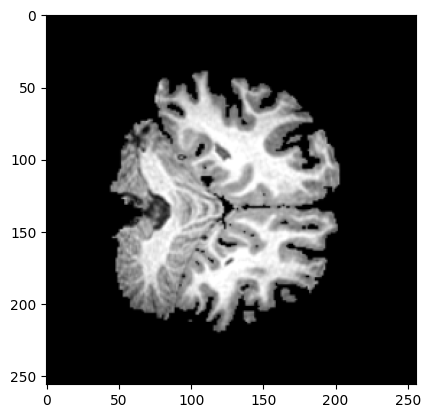

In [11]:
sd_slice = 40
sd_img, sd_seg, *_  = datasets['abide_stanford'].get_preprocessed_items(sd_slice)
plot_torch_img(sd_img)

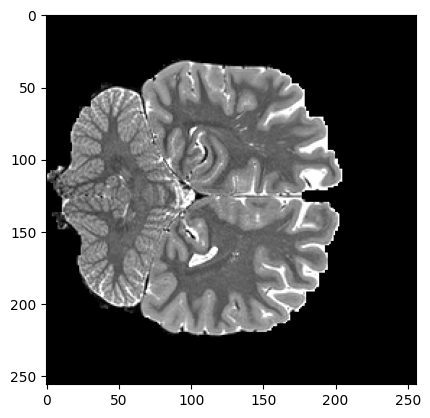

In [12]:
td_slice = 80
td_img, td_seg, *_  = datasets['hcp_t2'].get_preprocessed_items(td_slice)
plot_torch_img(td_img)

In [13]:
dataset_and_slices = (
    # ('abide_stanford', 64),
    # ('hcp_t2', 128),
    ('abide_stanford', 40),
    ('hcp_t2', 80),
)

images = list()

for dataset_name, slice in dataset_and_slices:
    img, seg, *_ = datasets[dataset_name].get_preprocessed_items(slice)
    img_dino_fe = get_dino_features(dino, img, hierarchy_level)
    img_pcs = ipca.img_to_pcs(img_dino_fe)[0]

    images.append((img, seg, img_pcs))

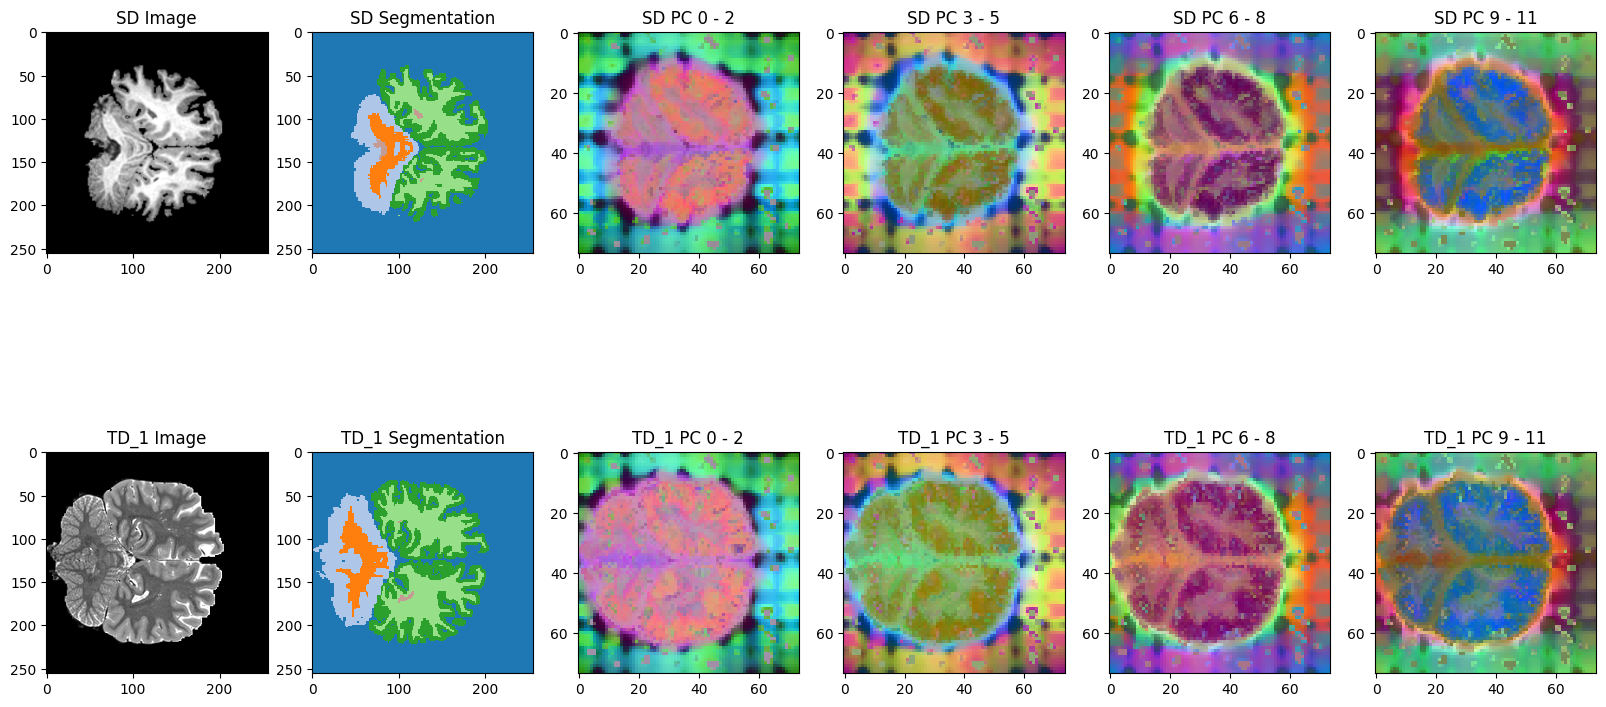

In [14]:
plot_sd_and_td_imgs_w_pcs(images, range(4), n_classes=15)

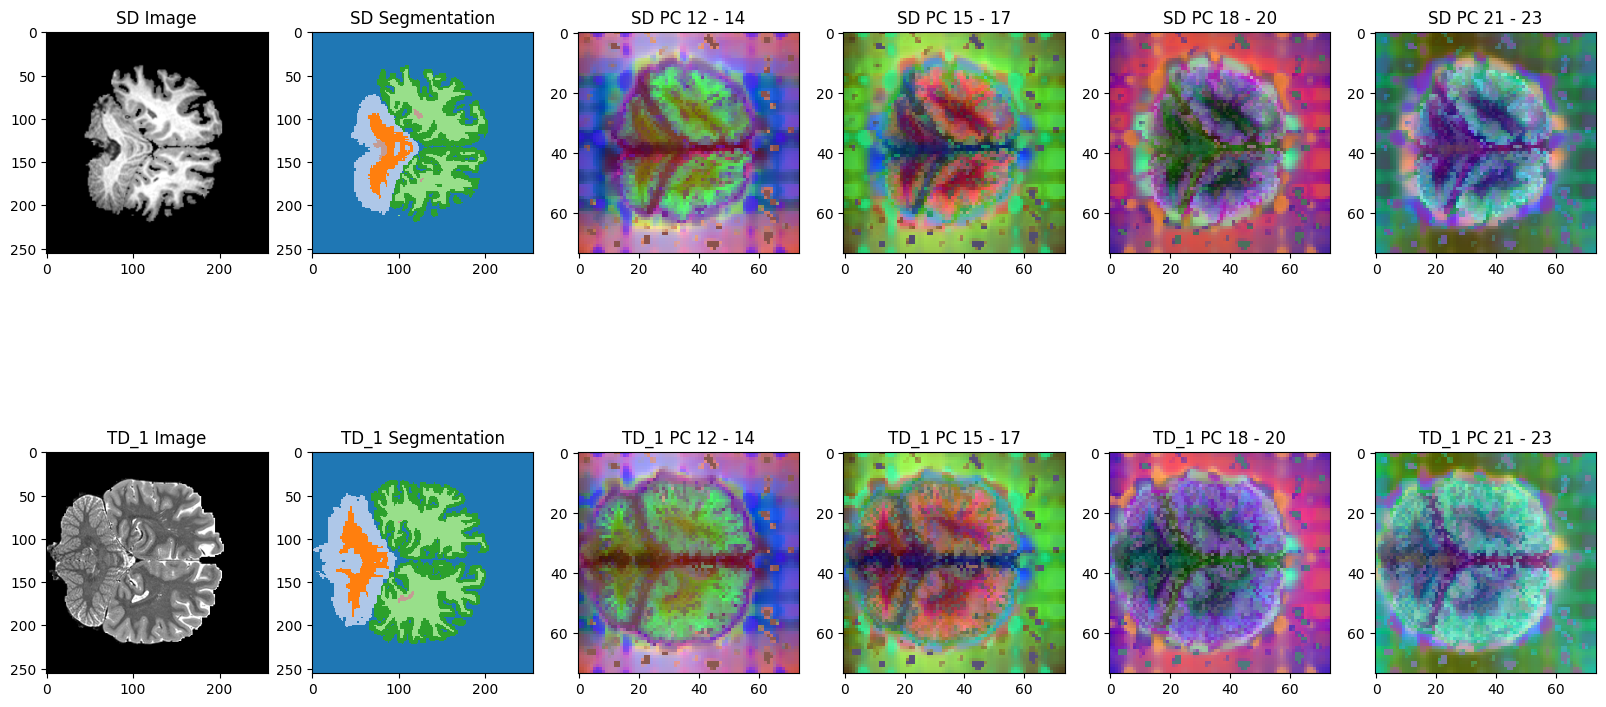

In [15]:
plot_sd_and_td_imgs_w_pcs(images, range(4, 8), n_classes=15)

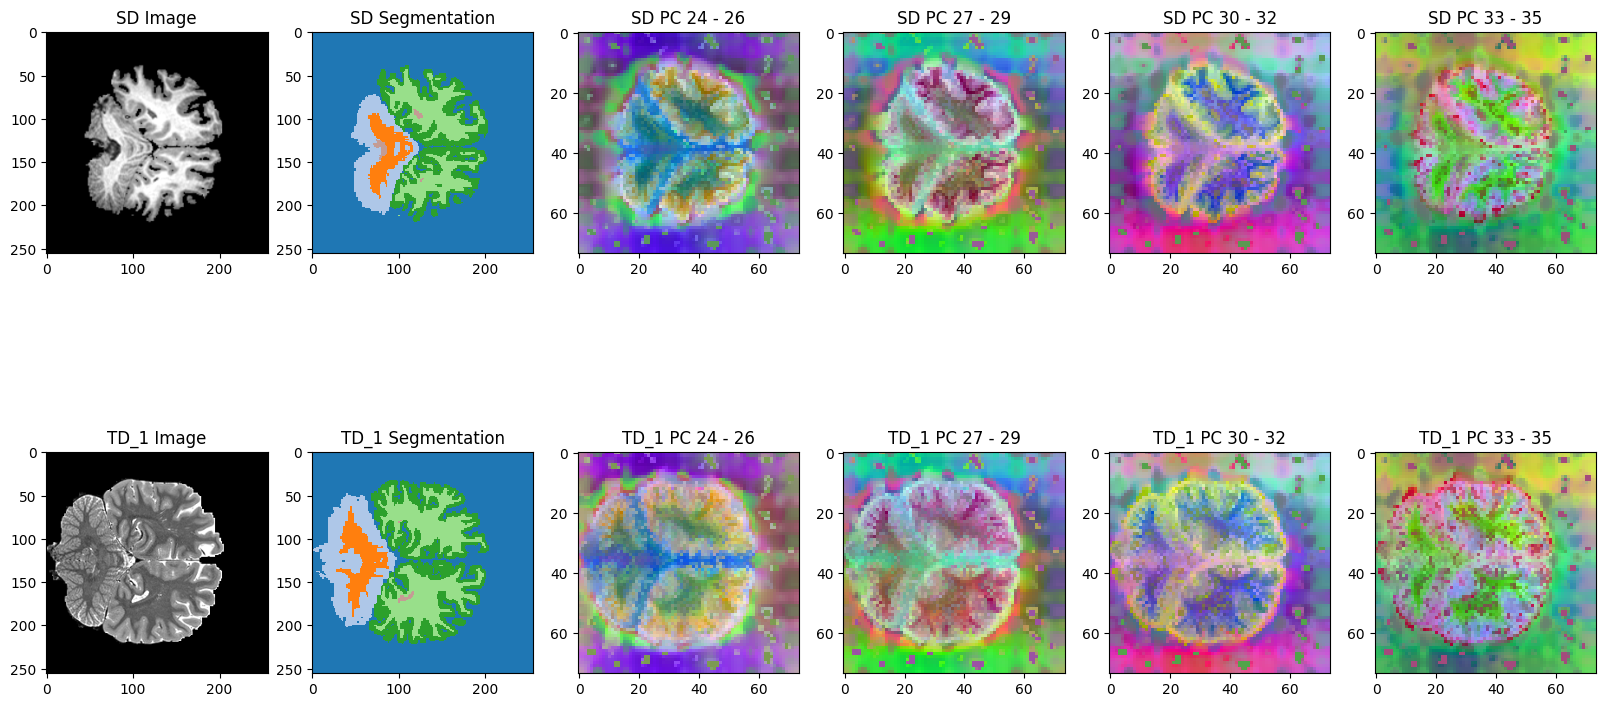

In [16]:
plot_sd_and_td_imgs_w_pcs(images, range(8, 12), n_classes=15)

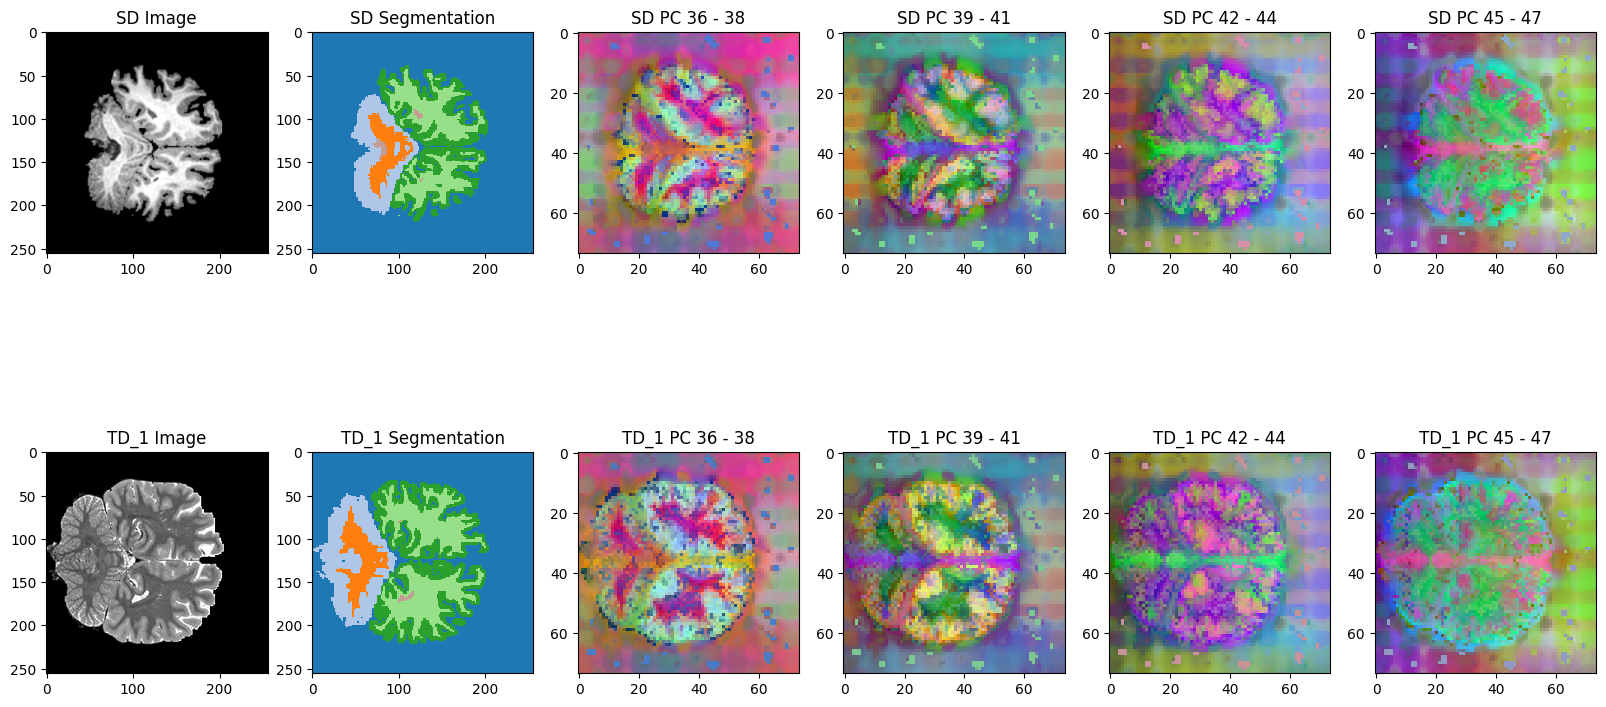

In [17]:
plot_sd_and_td_imgs_w_pcs(images, range(12, 16), n_classes=15)

Looks good. Repeat when computing in PCs with Pytorch and check we get the same images

### Check how it looks for WMH lesions

In [18]:
dataset_names = ['umc', 'vu', 'nuhs']
split = 'train'
dino_model = 'large'
hierarchy_level = 2

dataset_cfg_all = load_config('../../config/datasets.yaml')

datasets = dict()
for dataset_name in dataset_names:
    dataset_cfg = dataset_cfg_all[dataset_name]

    dataset_kwargs = dict(
        dataset_type    = 'Normal',
        splits          = [split],
        paths_preprocessed = dataset_cfg['paths_preprocessed'],
        paths_original  = dataset_cfg['paths_original'],
        resolution_proc = dataset_cfg['resolution_proc'],
        dim_proc        = dataset_cfg['dim'],
        n_classes       = dataset_cfg['n_classes'],
        load_original   = False,
        load_in_memory  = False,
        aug_params      = None,
        mode            = '2D',
        orientation     = 'depth'  
    )

    datasets[dataset_name] = get_datasets(
        dataset_name=dataset_name,
        **dataset_kwargs
        )[0]


In [19]:
dataset_and_slices = (
    ('umc', 26),
    ('vu', 27),
    ('nuhs', 26),
)

images = list()

for dataset_name, slice in dataset_and_slices:
    img, seg, *_ = datasets[dataset_name].get_preprocessed_items(slice)
    img_dino_fe = get_dino_features(dino, img, hierarchy_level)
    img_pcs = ipca.img_to_pcs(img_dino_fe)[0]

    images.append((img, seg, img_pcs))

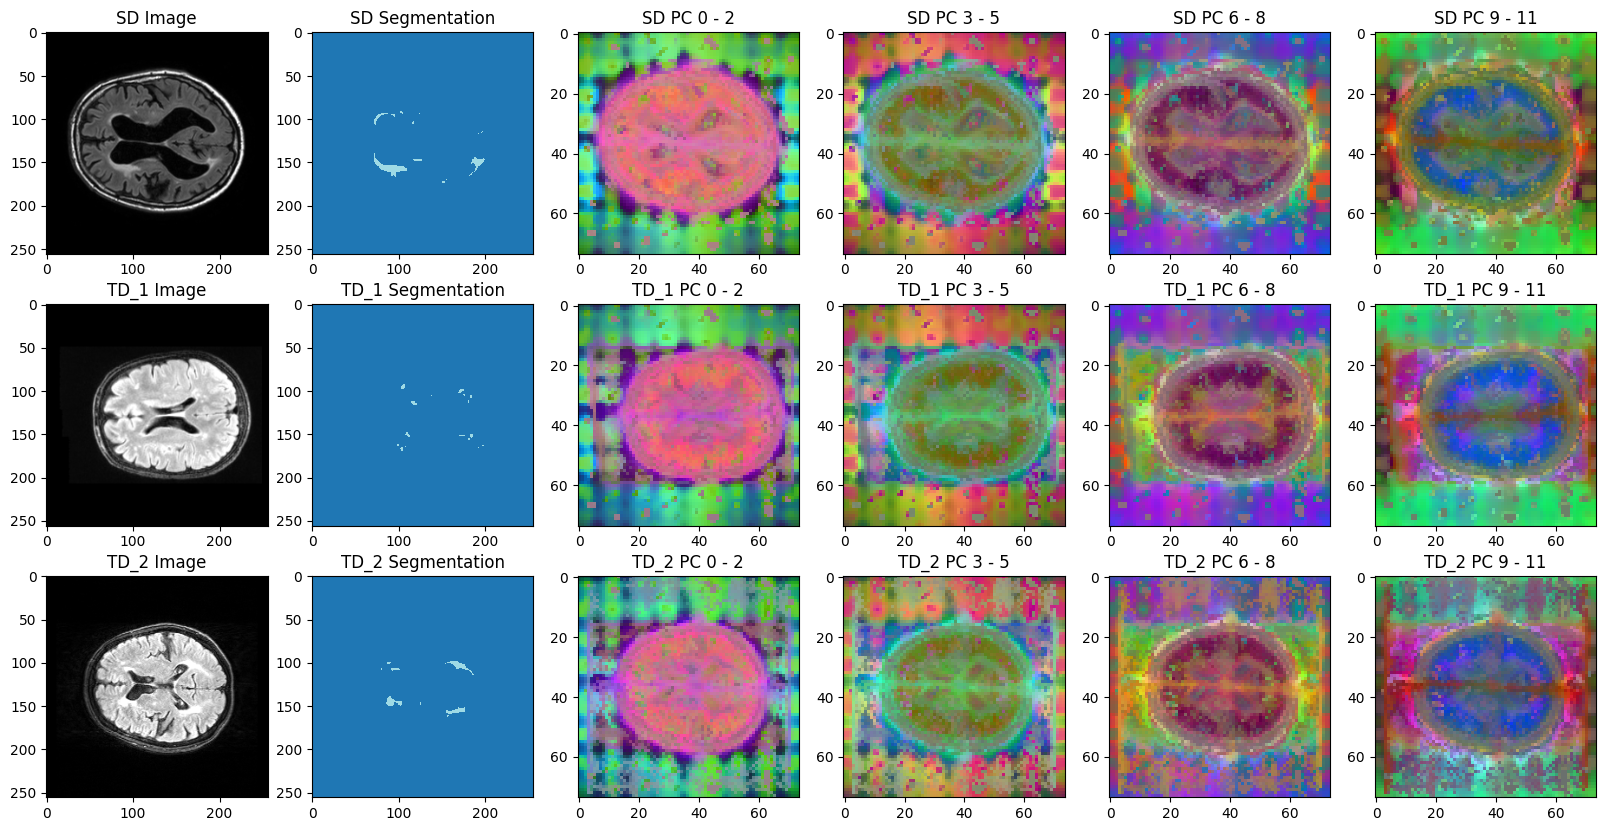

In [20]:
plot_sd_and_td_imgs_w_pcs(images, range(4), n_classes=2)

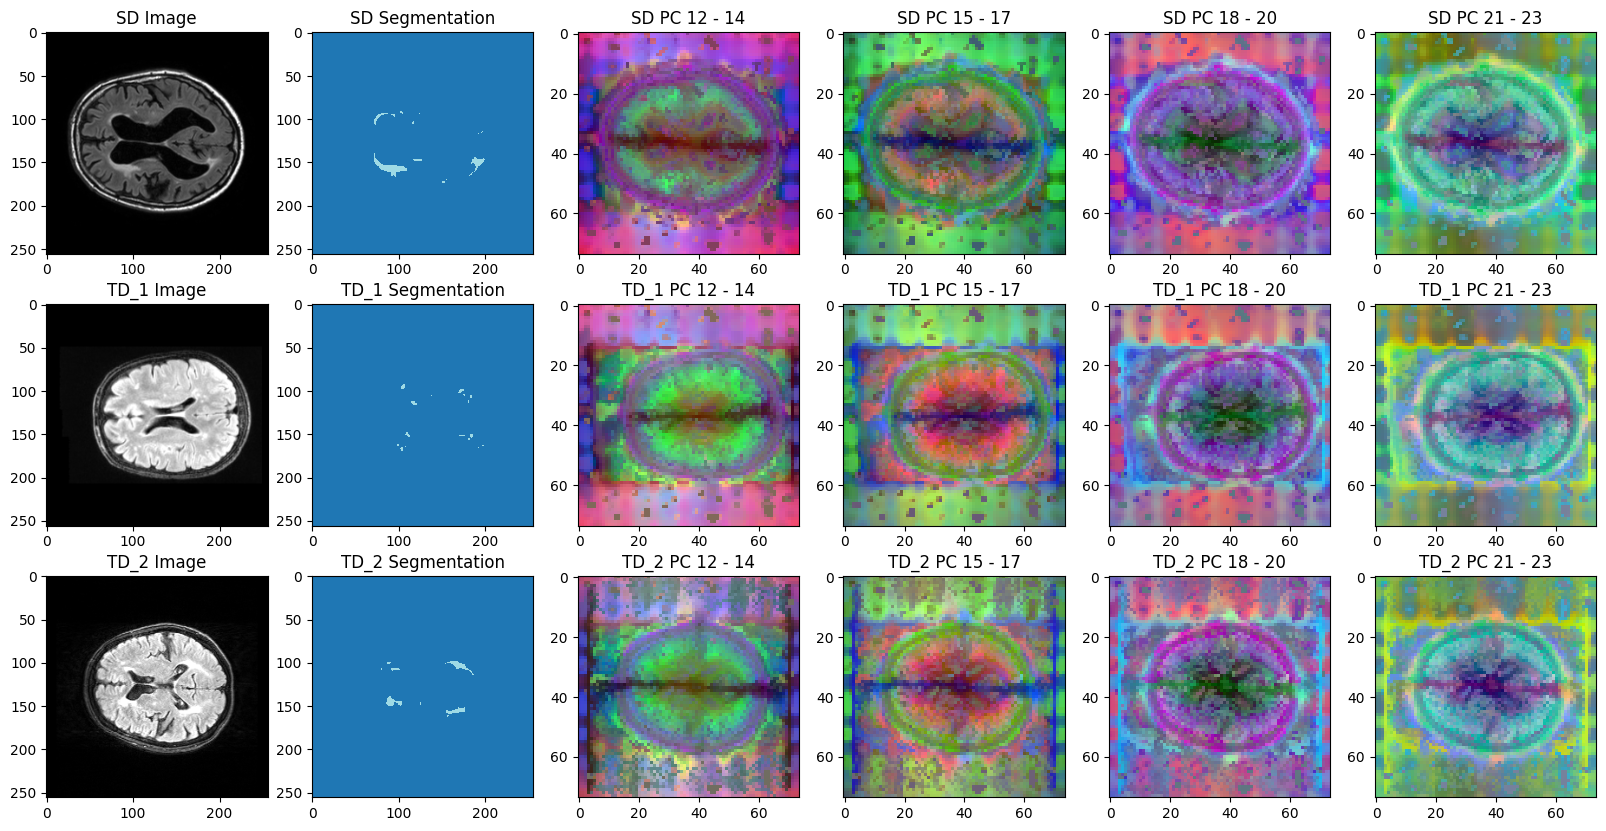

In [21]:
plot_sd_and_td_imgs_w_pcs(images, range(4, 8), n_classes=2)

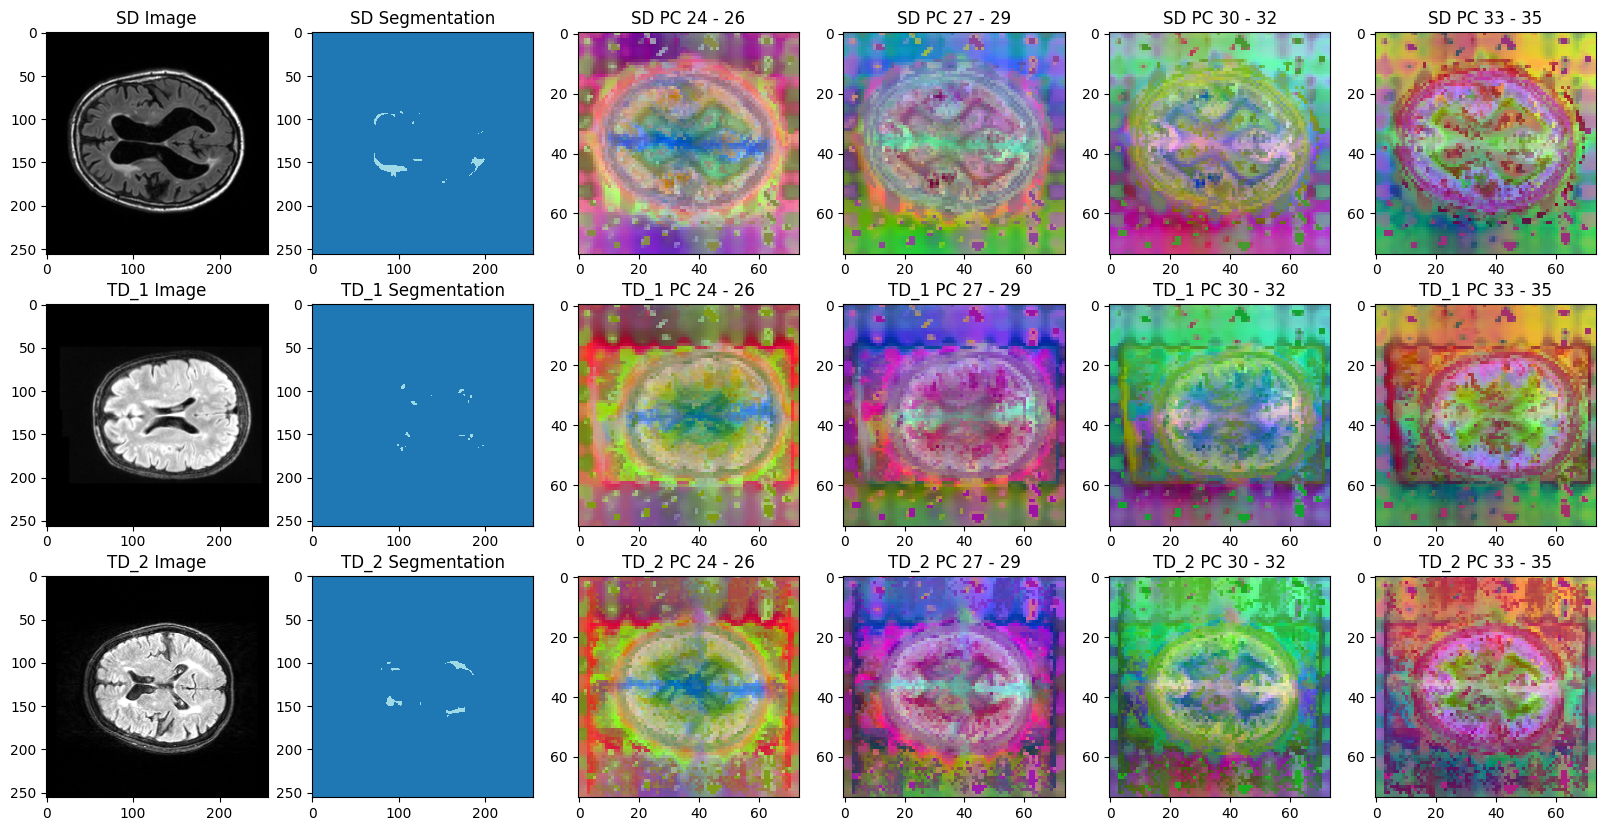

In [22]:
plot_sd_and_td_imgs_w_pcs(images, range(8, 12), n_classes=2)

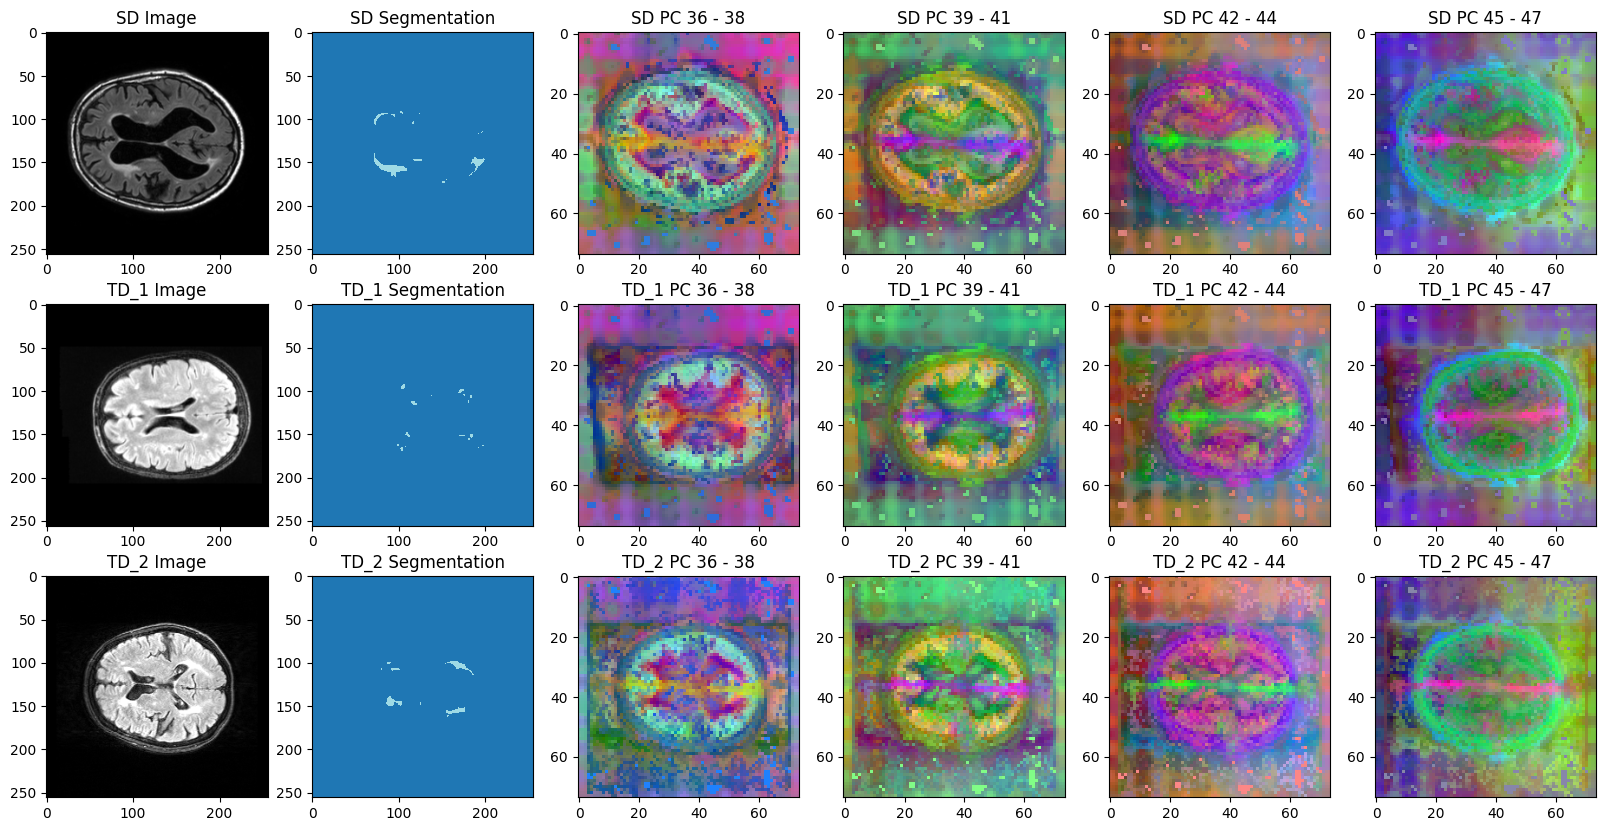

In [23]:
plot_sd_and_td_imgs_w_pcs(images, range(12, 16), n_classes=2)